# Train 1D CNN

1D Convolution을 기본 구성 요소로 하는 EEG classifier를 학습해보는 노트북.

- Three-way SoftMax classifier of normal, non-vascular MCI, and non-vascular dementia

-----

## 환경 구성

In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Load some packages
import os
import glob
import json
import datetime
from copy import deepcopy

import matplotlib.pyplot as plt
import pprint
from IPython.display import clear_output
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from tqdm.auto import tqdm
 
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from typing import Type, Any, Callable, Union, List, Optional
from itertools import cycle

# custom package
from utils.eeg_dataset import *

In [3]:
# notebook name
def get_notebook_name():
    import ipynbname
    return ipynbname.name()

nb_fname = get_notebook_name()

In [4]:
# Other settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # cleaner text

plt.style.use('default') 
# ['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 
#  'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 
#  'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 
#  'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 
#  'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']

plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams["font.family"] = 'NanumGothic' # for Hangul in Windows

In [5]:
print('PyTorch version:', torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available(): print('cuda is available.')
else: print('cuda is unavailable.')

PyTorch version: 1.7.1
cuda is available.


In [6]:
# Data file path
data_path = r'dataset/02_Curated_Data/'
meta_path = os.path.join(data_path, 'metadata_debug.json')

with open(meta_path, 'r') as json_file:
    metadata = json.load(json_file)

pprint.pprint(metadata[0])

{'age': 78,
 'birth': '1940-06-02',
 'dx1': 'mci_rf',
 'edfname': '00001809_261018',
 'events': [[0, 'Start Recording'],
            [0, 'New Montage - Montage 002'],
            [36396, 'Eyes Open'],
            [72518, 'Eyes Closed'],
            [73862, 'Eyes Open'],
            [75248, 'Eyes Closed'],
            [76728, 'swallowing'],
            [77978, 'Eyes Open'],
            [79406, 'Eyes Closed'],
            [79996, 'Photic On - 3.0 Hz'],
            [80288, 'Eyes Open'],
            [81296, 'Eyes Closed'],
            [82054, 'Photic Off'],
            [84070, 'Photic On - 6.0 Hz'],
            [84488, 'Eyes Open'],
            [85538, 'Eyes Closed'],
            [86086, 'Photic Off'],
            [88144, 'Photic On - 9.0 Hz'],
            [90160, 'Photic Off'],
            [91458, 'Eyes Open'],
            [92218, 'Photic On - 12.0 Hz'],
            [92762, 'Eyes Closed'],
            [94198, 'Photic Off'],
            [94742, 'Eyes Open'],
            [95708, 'Eyes Close

-----

## Data Filtering by Diagnosis

#### Non-Vascular Dementia, Non-Vascular MCI, Normal

In [7]:
diagnosis_filter = [
    # Normal
    {'type': 'Normal',
     'include': ['normal'], 
     'exclude': []},
    # Non-vascular MCI
    {'type': 'Non-vascular MCI',
     'include': ['mci'], 
     'exclude': ['mci_vascular']},
    # Non-vascular dementia
    {'type': 'Non-vascular dementia',
     'include': ['dementia'], 
     'exclude': ['vd']},
]

def generate_class_label(label):
    for c, f in enumerate(diagnosis_filter):
        inc = set(f['include']) & set(label) == set(f['include'])
        # inc = len(set(f['include']) & set(label)) > 0        
        exc = len(set(f['exclude']) & set(label)) == 0
        if  inc and exc:
            return (c, f['type'])
    return (-1, 'The others')

class_label_to_type = [d_f['type'] for d_f in diagnosis_filter]
print('class_label_to_type:', class_label_to_type)

class_label_to_type: ['Normal', 'Non-vascular MCI', 'Non-vascular dementia']


In [8]:
splitted_metadata = [[] for i in diagnosis_filter]

for m in metadata:
    c, n = generate_class_label(m['label'])
    if c >= 0:
        m['class_type'] = n
        m['class_label'] = c
        splitted_metadata[c].append(m)
        
for i, split in enumerate(splitted_metadata):
    if len(split) == 0:
        print(f'(Warning) Split group {i} has no data.')
    else:
        print(f'- There are {len(split):} data belonging to {split[0]["class_type"]}')

- There are 463 data belonging to Normal
- There are 347 data belonging to Non-vascular MCI
- There are 229 data belonging to Non-vascular dementia


-----

## Configure the Train, Validation, and Test Splits

#### Split the filtered dataset and shuffle them

In [9]:
# random seed
random.seed(0)

# Train : Val : Test = 8 : 1 : 1
ratio1 = 0.8
ratio2 = 0.1

metadata_train = []
metadata_val = []
metadata_test = []

for split in splitted_metadata:
    random.shuffle(split)
    
    n1 = round(len(split) * ratio1)
    n2 = n1 + round(len(split) * ratio2)

    metadata_train.extend(split[:n1])
    metadata_val.extend(split[n1:n2])
    metadata_test.extend(split[n2:])

random.shuffle(metadata_train)
random.shuffle(metadata_val)
random.shuffle(metadata_test)

print('Train data size\t\t:', len(metadata_train))
print('Validation data size\t:', len(metadata_val))
print('Test data size\t\t:', len(metadata_test))

print('\n', '--- Recheck ---', '\n')
train_class_nums = np.zeros((len(class_label_to_type)), dtype=np.int32)
for m in metadata_train:
    train_class_nums[m['class_label']] += 1

val_class_nums = np.zeros((len(class_label_to_type)), dtype=np.int32)
for m in metadata_val:
    val_class_nums[m['class_label']] += 1

test_class_nums = np.zeros((len(class_label_to_type)), dtype=np.int32)
for m in metadata_test:
    test_class_nums[m['class_label']] += 1

print('Train data label distribution\t:', train_class_nums, train_class_nums.sum())
print('Val data label distribution\t:', val_class_nums, val_class_nums.sum())
print('Test data label distribution\t:', test_class_nums, test_class_nums.sum())

# random seed
random.seed()

# print([m['serial']  for m in metadata_train[:15]])
# print([m['serial']  for m in metadata_val[:15]])
# print([m['serial']  for m in metadata_test[:15]])

Train data size		: 831
Validation data size	: 104
Test data size		: 104

 --- Recheck --- 

Train data label distribution	: [370 278 183] 831
Val data label distribution	: [46 35 23] 104
Test data label distribution	: [47 34 23] 104


#### Wrap the splitted data using PyTorch Dataset

In [10]:
ages = []
for m in metadata_train:
    ages.append(m['age'])

ages = np.array(ages)
age_mean = np.mean(ages)
age_std = np.std(ages)

print('Age mean and standard deviation:')
print(age_mean, age_std)

Age mean and standard deviation:
69.92779783393502 9.817569889945597


In [11]:
crop_length = 200*2 # 2 seconds

composed = transforms.Compose([EEGNormalizeAge(mean=age_mean, std=age_std),
                               EEGDropPhoticChannel(),
                               EEGRandomCrop(crop_length=crop_length),
                               EEGNormalizePerSignal(),
                               EEGToTensor()])

train_dataset = EEGDataset(data_path, metadata_train, composed)
val_dataset = EEGDataset(data_path, metadata_val, composed)
test_dataset = EEGDataset(data_path, metadata_test, composed)

print(train_dataset[0]['signal'].shape)
print(train_dataset[0])

print()
print('-' * 100)
print()

print(val_dataset[0]['signal'].shape)
print(val_dataset[0])

print()
print('-' * 100)
print()

print(test_dataset[0]['signal'].shape)
print(test_dataset[0])

torch.Size([20, 400])
{'signal': tensor([[-1.6357, -1.3654, -1.5276,  ...,  1.7151,  1.4449,  1.4989],
        [ 1.4724,  1.1122,  0.8421,  ...,  1.3824,  1.1122,  0.7521],
        [ 1.8504,  1.8504,  1.8504,  ..., -2.0063, -2.3466, -2.8003],
        ...,
        [-0.6764, -1.3856, -1.7401,  ...,  1.5693,  1.5693,  1.5693],
        [-2.7571, -2.8840, -2.5032,  ..., -0.7261, -0.4722, -0.3453],
        [ 0.1182, -0.0417, -0.0110,  ...,  0.0198, -0.0356, -0.0540]]), 'age': tensor(-1.2149), 'class_label': tensor(0), 'metadata': {'serial': '01012', 'edfname': '01212635_270515', 'birth': '1956-06-01', 'record': '2015-05-27T09:37:24', 'age': 58, 'dx1': 'cb_normal', 'label': ['normal', 'cb_normal'], 'events': [[0, 'Start Recording'], [0, 'New Montage - Montage 002'], [400, 'Eyes Open'], [7918, 'Eyes Closed'], [14091, 'Eyes Open'], [18208, 'Eyes Closed'], [24256, 'Eyes Open'], [30724, 'Eyes Closed'], [36562, 'Eyes Open'], [42190, 'Eyes Closed'], [48910, 'Eyes Open'], [55126, 'Eyes Closed'], [60

#### Data loader test

In [12]:
print('Current PyTorch device:', device)
if device.type == 'cuda':
    num_workers = 0 # A number other than 0 causes an error
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = DataLoader(train_dataset, 
                          batch_size=32, 
                          shuffle=True, 
                          drop_last=True,
                          num_workers=num_workers, 
                          pin_memory=pin_memory,
                          collate_fn=eeg_collate_fn)

for i_batch, sample_batched in enumerate(train_loader):
    sample_batched['signal'].to(device)
    sample_batched['age'].to(device)
    sample_batched['class_label'].to(device)
    
    print(i_batch, 
          sample_batched['signal'].shape, 
          sample_batched['age'].shape, 
          sample_batched['class_label'].shape, 
          len(sample_batched['metadata']))
    
    if i_batch > 3:
        break

Current PyTorch device: cuda
0 torch.Size([32, 20, 400]) torch.Size([32]) torch.Size([32]) 32
1 torch.Size([32, 20, 400]) torch.Size([32]) torch.Size([32]) 32
2 torch.Size([32, 20, 400]) torch.Size([32]) torch.Size([32]) 32
3 torch.Size([32, 20, 400]) torch.Size([32]) torch.Size([32]) 32
4 torch.Size([32, 20, 400]) torch.Size([32]) torch.Size([32]) 32


#### Train, validation, test dataloaders

In [13]:
train_loader = DataLoader(train_dataset, 
                          batch_size=32, 
                          shuffle=True, 
                          drop_last=True,
                          num_workers=num_workers, 
                          pin_memory=pin_memory,
                          collate_fn=eeg_collate_fn)

val_loader = DataLoader(val_dataset, 
                        batch_size=32, 
                        shuffle=False, 
                        drop_last=False,
                        num_workers=num_workers, 
                        pin_memory=pin_memory,
                        collate_fn=eeg_collate_fn)

test_loader = DataLoader(test_dataset, 
                         batch_size=32, 
                         shuffle=False, 
                         drop_last=False,
                         num_workers=num_workers, 
                         pin_memory=pin_memory,
                         collate_fn=eeg_collate_fn)

-----

## Define 1D CNN models

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def visualize_network_tensorboard(model, name):
    from torch.utils.tensorboard import SummaryWriter
    
    # default `log_dir` is "runs" - we'll be more specific here
    writer = SummaryWriter('runs/' + nb_fname + '_' + name)

    for batch_i, sample_batched in enumerate(train_loader):
        # pull up the batch data
        x = sample_batched['signal'].to(device)
        age = sample_batched['age'].to(device)
        target = sample_batched['class_label'].to(device)

        # apply model on whole batch directly on device
        writer.add_graph(model, (x, age))
        output = model(x, age, print_shape=True)
        break
        
    writer.close()

#### 1D Tiny CNN

In [15]:
class TinyCNN(nn.Module):
    def __init__(self, n_input=20, n_output=3, stride=5, n_channel=64, 
                 use_age=True, final_pool='average'):
        super().__init__()
        
        if final_pool not in {'average', 'max'}:
            raise ValueError("final_pool must be set to one of ['average', 'max']")
        
        self.use_age = use_age
        
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=35, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(3)
        
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=7)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(2)
        
        if final_pool == 'average':
            self.final_pool = nn.AdaptiveAvgPool1d(1)
        elif final_pool == 'max':
            self.final_pool = nn.AdaptiveMaxPool1d(1)
        
        if self.use_age:        
            self.fc1 = nn.Linear(n_channel + 1, n_channel)
        else:
            self.fc1 = nn.Linear(n_channel, n_channel)
            
        self.dropout = nn.Dropout(p=0.3)
        self.bnfc1 = nn.BatchNorm1d(n_channel)
        self.fc2 = nn.Linear(n_channel, n_output)
        
    def reset_weights(self):
        for m in self.modules():
            if hasattr(m, 'reset_parameters'):
                m.reset_parameters()

    def forward(self, x, age, print_shape=False):
        # conv-bn-relu-pool 
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        
        if print_shape:
            print(x.shape)
        
        x = self.final_pool(x).squeeze()
        if self.use_age:
            x = torch.cat((x, age.reshape(-1, 1)), dim=1)

        # fc-bn-dropout-relu-fc
        x = self.fc1(x)
        x = self.bnfc1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        return x
        # return F.log_softmax(x, dim=1)

In [16]:
def generate_TinyCNN():
    return TinyCNN(n_input=train_dataset[0]['signal'].shape[0], 
                   n_output=3, use_age=True, final_pool='max')

In [17]:
model = generate_TinyCNN()
model = model.to(device, dtype=torch.float32)
print(model)
print()

# tensorboard visualization
visualize_network_tensorboard(model, 'TinyCNN')

# number of parameters
n = count_parameters(model)
print(f'The Number of parameters of the model: {n:,}')

del model

TinyCNN(
  (conv1): Conv1d(20, 64, kernel_size=(35,), stride=(5,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 64, kernel_size=(7,), stride=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (final_pool): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=65, out_features=64, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (bnfc1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=64, out_features=3, bias=True)
)

torch.Size([32, 64, 9])
The Number of parameters of the model: 78,403


#### M5-like model

In [18]:
class M5(nn.Module):
    def __init__(self, n_input=20, n_output=3, stride=2, n_channel=256, 
                 use_age=True, final_pool='average'):
        super().__init__()
        
        if final_pool not in {'average', 'max'}:
            raise ValueError("final_pool must be set to one of ['average', 'max']")
        
        self.use_age = use_age
        
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=35)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(2)
        
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=11)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(2)
        
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=11)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(2)
        
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=11)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        # self.pool4 = nn.MaxPool1d(2)
        
        self.conv5 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=11)
        self.bn5 = nn.BatchNorm1d(2 * n_channel)
        self.pool5 = nn.MaxPool1d(2)
        
        if final_pool == 'average':
            self.final_pool = nn.AdaptiveAvgPool1d(1)
        elif final_pool == 'max':
            self.final_pool = nn.AdaptiveMaxPool1d(1)
    
        if self.use_age:        
            self.fc1 = nn.Linear(2 * n_channel + 1, 2 * n_channel)
        else:
            self.fc1 = nn.Linear(2 * n_channel, 2 * n_channel)
            
        self.dropout = nn.Dropout(p=0.3)
        self.bnfc1 = nn.BatchNorm1d(2 * n_channel)
        self.fc2 = nn.Linear(2 * n_channel, n_output)
        
    def reset_weights(self):
        for m in self.modules():
            if hasattr(m, 'reset_parameters'):
                m.reset_parameters()

    def forward(self, x, age, print_shape=False):
        # conv-bn-relu-pool 
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)

        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)

        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        # x = self.pool4(x)

        x = self.conv5(x)
        x = F.relu(self.bn5(x))
        x = self.pool5(x)
        
        if print_shape:
            print(x.shape)
        
        x = self.final_pool(x).squeeze()
        if self.use_age:
            x = torch.cat((x, age.reshape(-1, 1)), dim=1)

        # fc-bn-dropout-relu-fc
        x = self.fc1(x)
        x = self.bnfc1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        return x
        # return F.log_softmax(x, dim=1)

In [19]:
def generate_M5():
    return M5(n_input=train_dataset[0]['signal'].shape[0], 
              n_output=3, use_age=True, final_pool='max')

In [20]:
model = generate_M5()
model = model.to(device, dtype=torch.float32)
print(model)
print()

# tensorboard visualization
visualize_network_tensorboard(model, 'M5')

# number of parameters
n = count_parameters(model)
print(f'The Number of parameters of the model: {n:,}')

del model

M5(
  (conv1): Conv1d(20, 256, kernel_size=(35,), stride=(1,))
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(256, 256, kernel_size=(11,), stride=(1,))
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(256, 512, kernel_size=(11,), stride=(1,))
  (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(512, 512, kernel_size=(11,), stride=(1,))
  (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv1d(512, 512, kernel_size=(11,), stride=(1,))
  (bn5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_s

#### M5-like model without the usage of age

In [21]:
def generate_M5_no_age():
    return M5(n_input=train_dataset[0]['signal'].shape[0], 
              n_output=3, use_age=False, final_pool='max')

In [22]:
model = generate_M5_no_age()
model = model.to(device, dtype=torch.float32)
print(model)
print()

# tensorboard visualization
visualize_network_tensorboard(model, 'M5-no-age')

# number of parameters
n = count_parameters(model)
print(f'The Number of parameters of the model: {n:,}')

del model

M5(
  (conv1): Conv1d(20, 256, kernel_size=(35,), stride=(1,))
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(256, 256, kernel_size=(11,), stride=(1,))
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(256, 512, kernel_size=(11,), stride=(1,))
  (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(512, 512, kernel_size=(11,), stride=(1,))
  (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv1d(512, 512, kernel_size=(11,), stride=(1,))
  (bn5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_s

#### 1D ResNet model

In [23]:
class BasicResBlock(nn.Module):
    expansion: int = 1

    def __init__(self, c_in, c_out, kernel_size, stride) -> None:
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=c_in, out_channels=c_out, 
                               kernel_size=kernel_size, stride=stride, 
                               padding=kernel_size//2, bias=False)
        self.bn1 = nn.BatchNorm1d(c_out)

        self.conv2 = nn.Conv1d(in_channels=c_out, out_channels=c_out, 
                               kernel_size=kernel_size, stride=1, 
                               padding=kernel_size//2, bias=False)
        self.bn2 = nn.BatchNorm1d(c_out)

        self.relu = nn.ReLU(inplace=True)
        
        self.downsample = None
        if stride != 1 or c_in != c_out:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels=c_in, out_channels=c_out, 
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(c_out)
            )
                    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        if self.downsample is not None:
            identity = self.downsample(identity)
        x = self.relu(x + identity)
        
        return x

In [24]:
class BottleneckBlock(nn.Module):
    expansion: int = 4
        
    def __init__(self, c_in, c_out, kernel_size, stride) -> None:
        super().__init__()
        width = c_out
        self.conv1 = nn.Conv1d(in_channels=c_in, out_channels=width, 
                               kernel_size=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm1d(width)

        self.conv2 = nn.Conv1d(in_channels=width, out_channels=width, 
                               kernel_size=kernel_size, stride=stride, 
                               padding=kernel_size//2, bias=False)
        self.bn2 = nn.BatchNorm1d(width)

        self.conv3 = nn.Conv1d(in_channels=width, out_channels=c_out*self.expansion, 
                               kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm1d(c_out*self.expansion)
        
        self.relu = nn.ReLU(inplace=True)
        
        self.downsample = None
        if stride != 1 or c_in != c_out*self.expansion:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels=c_in, out_channels=c_out*self.expansion, 
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(c_out*self.expansion)
            )
                    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        if self.downsample is not None:
            identity = self.downsample(identity)
            
        x = self.relu(x + identity)
        
        return x

In [25]:
class ResNet(nn.Module):
    def __init__(self, 
                 block: Type[Union[BasicResBlock, BottleneckBlock]], 
                 conv_layers: List[int],
                 n_fc: int,
                 n_input=20,
                 n_output=3,
                 n_start=64,
                 kernel_size=9, 
                 use_age=True, 
                 final_pool='average') -> None:
        
        super().__init__()
        
        if final_pool not in {'average', 'max'}:
            raise ValueError("final_pool must be set to one of ['average', 'max']")        

        self.c_current = n_start
        self.use_age = use_age
        
        self.input_stage = nn.Sequential(
            nn.Conv1d(in_channels=n_input, out_channels=n_start, 
                      kernel_size=kernel_size*3, stride=2,
                      padding=(kernel_size*3)//2, bias=False),
            nn.BatchNorm1d(n_start), 
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        
        self.conv_stage1 = self._make_conv_layer(block, conv_layers[0], n_start, kernel_size, stride=2)
        self.conv_stage2 = self._make_conv_layer(block, conv_layers[1], n_start*2, kernel_size, stride=2)
        self.conv_stage3 = self._make_conv_layer(block, conv_layers[2], n_start*4, kernel_size, stride=2)
        self.conv_stage4 = self._make_conv_layer(block, conv_layers[3], n_start*8, kernel_size, stride=2)
        
        if final_pool == 'average':
            self.final_pool = nn.AdaptiveAvgPool1d(1)
        elif final_pool == 'max':
            self.final_pool = nn.AdaptiveMaxPool1d(1)
        
        fc_layers = []        
        if self.use_age:
            self.c_current = self.c_current + 1
        
        for l in range(n_fc):
            layer = nn.Sequential(nn.Linear(self.c_current, self.c_current // 2, bias=False),
                                  nn.Dropout(p=0.1),
                                  nn.BatchNorm1d(self.c_current // 2), 
                                  nn.ReLU())
            self.c_current = self.c_current // 2
            fc_layers.append(layer)
        fc_layers.append(nn.Linear(self.c_current, n_output))
        self.fc_stage = nn.Sequential(*fc_layers)
        
    def reset_weights(self):
        for m in self.modules():
            if hasattr(m, 'reset_parameters'):
                m.reset_parameters()
        
    def _make_conv_layer(self, block: Type[Union[BasicResBlock, BottleneckBlock]], 
                         n_block: int, c_out: int, kernel_size: int, stride: int = 1) -> nn.Sequential:
        layers = []
        c_in = self.c_current
        layers.append(block(c_in, c_out, kernel_size, stride=1))

        c_in = c_out * block.expansion
        self.c_current = c_in
        for _ in range(1, n_block):
            layers.append(block(c_in, c_out, kernel_size, stride=1))
            
        layers.append(nn.MaxPool1d(kernel_size=stride))
            
        return nn.Sequential(*layers)

    def forward(self, x, age, print_shape=False):
        x = self.input_stage(x)
        
        x = self.conv_stage1(x)
        x = self.conv_stage2(x)
        x = self.conv_stage3(x)
        x = self.conv_stage4(x)
        
        if print_shape:
            print(x.shape)

        x = self.final_pool(x).squeeze()
        if self.use_age:
            x = torch.cat((x, age.reshape(-1, 1)), dim=1)
        x = self.fc_stage(x)
        
        return x
        # return F.log_softmax(x, dim=2)

In [26]:
def generate_ResNet():
    return ResNet(block=BottleneckBlock, 
                  conv_layers=[2, 2, 2, 2], 
                  n_fc=3, 
                  n_input=train_dataset[0]['signal'].shape[0], 
                  n_output=3, 
                  n_start=64,
                  kernel_size=9, 
                  use_age=True, 
                  final_pool='max')

In [27]:
model = generate_ResNet()
model = model.to(device, dtype=torch.float32)
print(model)
print()

# tensorboard visualization
visualize_network_tensorboard(model, '1D-ResNet')

# number of parameters
n = count_parameters(model)
print(f'The Number of parameters of the model: {n:,}')

del model

ResNet(
  (input_stage): Sequential(
    (0): Conv1d(20, 64, kernel_size=(27,), stride=(2,), padding=(13,), bias=False)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_stage1): Sequential(
    (0): BottleneckBlock(
      (conv1): Conv1d(64, 64, kernel_size=(1,), stride=(1,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(64, 64, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv1d(64, 256, kernel_size=(1,), stride=(1,), bias=False)
      (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv1d(64, 256, kernel_size=(1,), stride

#### 1D CNN: ResNet-like model without the usage of age

In [28]:
def generate_ResNet_no_age():
    return ResNet(block=BottleneckBlock, 
                  conv_layers=[2, 2, 2, 2], 
                  n_fc=3, 
                  n_input=train_dataset[0]['signal'].shape[0], 
                  n_output=3, 
                  n_start=64,
                  kernel_size=9, 
                  use_age=False, 
                  final_pool='max')

In [29]:
model = generate_ResNet_no_age()
model = model.to(device, dtype=torch.float32)
print(model)
print()

# tensorboard visualization
visualize_network_tensorboard(model, '1D-ResNet-no-age')

# number of parameters
n = count_parameters(model)
print(f'The Number of parameters of the model: {n:,}')

del model

ResNet(
  (input_stage): Sequential(
    (0): Conv1d(20, 64, kernel_size=(27,), stride=(2,), padding=(13,), bias=False)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_stage1): Sequential(
    (0): BottleneckBlock(
      (conv1): Conv1d(64, 64, kernel_size=(1,), stride=(1,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(64, 64, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv1d(64, 256, kernel_size=(1,), stride=(1,), bias=False)
      (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv1d(64, 256, kernel_size=(1,), stride

#### 1D Tiny ResNet

In [30]:
def generate_TinyResNet():
    return ResNet(block=BasicResBlock, 
                  conv_layers=[1, 1, 1, 1], 
                  n_fc=3, 
                  n_input=train_dataset[0]['signal'].shape[0], 
                  n_output=3, 
                  n_start=64,
                  kernel_size=9, 
                  use_age=False)

In [31]:
model = generate_TinyResNet()
model = model.to(device, dtype=torch.float32)
print(model)
print()

n = count_parameters(model)
print(f'The Number of parameters of the model: {n:,}')

del model

ResNet(
  (input_stage): Sequential(
    (0): Conv1d(20, 64, kernel_size=(27,), stride=(2,), padding=(13,), bias=False)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_stage1): Sequential(
    (0): BasicResBlock(
      (conv1): Conv1d(64, 64, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(64, 64, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_stage2): Sequential(
    (0): BasicResBlock(
      (conv1): Conv1d(64, 128, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
      

-----

## Some useful functions for training

In [32]:
def check_val_accuracy(model, repeat=1):
    model.eval()
    correct, total = (0, 0)
        
    C = len(class_label_to_type)
    val_confusion = np.zeros((C, C), dtype=np.int32)
    
    for k in range(repeat):
        for sample_batched in val_loader:
            # pull up the data
            x = sample_batched['signal'].to(device)
            age = sample_batched['age'].to(device)
            target = sample_batched['class_label'].to(device)

            # apply model on whole batch directly on device
            output = model(x, age)
            pred = F.log_softmax(output, dim=1)

            # val accuracy
            pred = pred.argmax(dim=-1)
            correct += pred.squeeze().eq(target).sum().item()
            total += pred.shape[0]
            
            # confusion matrix
            val_confusion += calculate_confusion_matrix(pred, target)
            
    val_accuracy = 100.0 * correct / total
    return (val_accuracy, val_confusion)

    
def check_test_accuracy(model, repeat=1):
    model.eval()
    correct, total = (0, 0)
    
    C = len(class_label_to_type)
    test_confusion = np.zeros((C, C), dtype=np.int32)
    
    test_debug = {data['metadata']['serial']: 
                  {'GT': data['class_label'].item(), 
                   'Acc': 0, 
                   'Pred': [0] * C} for data in test_dataset}
    
    score = None
    target = None
        
    for k in range(repeat):
        for sample_batched in test_loader:
            # pull up the data
            x = sample_batched['signal'].to(device)
            age = sample_batched['age'].to(device)
            y = sample_batched['class_label'].to(device)

            # apply model on whole batch directly on device
            output = model(x, age)
            s = F.softmax(output, dim=1)
            pred = F.log_softmax(output, dim=1)
            
            # test accuracy
            pred = pred.argmax(dim=-1)
            correct += pred.squeeze().eq(y).sum().item()
            total += pred.shape[0]
            
            if score is None:
                score = s.detach().cpu().numpy()
                target = y.detach().cpu().numpy()
            else:
                score = np.concatenate((score, s.detach().cpu().numpy()), axis=0)
                target = np.concatenate((target, y.detach().cpu().numpy()), axis=0)
            
            # confusion matrix
            test_confusion += calculate_confusion_matrix(pred, y)
            
            # test debug
            for n in range(pred.shape[0]):
                serial = sample_batched['metadata'][n]['serial']
                test_debug[serial]['edfname'] = sample_batched['metadata'][n]['edfname']
                test_debug[serial]['Pred'][pred[n].item()] += 1
                acc = test_debug[serial]['Pred'][y[n].item()] / np.sum(test_debug[serial]['Pred']) * 100
                test_debug[serial]['Acc'] = f'{acc:>6.02f}%'
        
    test_accuracy = 100.0 * correct / total
    return (test_accuracy, test_confusion, test_debug, score, target)


def calculate_confusion_matrix(pred, target):
    N = target.shape[0]
    C = len(class_label_to_type)
    confusion = np.zeros((C, C), dtype=np.int32)
    
    for i in range(N):
        r = target[i]
        c = pred[i]
        confusion[r, c] += 1
    return confusion

In [33]:
def draw_loss_plot(losses, lr_decay_step):
    plt.style.use('default') # default, ggplot, fivethirtyeight, classic
    fig = plt.figure(num=1, clear=True, figsize=(8.0, 3.0), constrained_layout=True)
    ax = fig.add_subplot(1, 1, 1)
    
    N = len(losses)
    x = np.arange(1, N + 1)
    ax.plot(x, losses)
        
    x2 = np.arange(lr_decay_step, N, lr_decay_step)
    ax.vlines(x2, 0, 1, transform=ax.get_xaxis_transform(), 
              colors='m', alpha=0.5, linestyle='solid')
    # ax.vlines([1, N], 0, 1, transform=ax.get_xaxis_transform(), 
    #           colors='k', alpha=0.7, linestyle='solid')
    
    ax.set_xlim(left=0)
    ax.set_title('Loss Plot')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Training Loss')
    
    plt.show()
    fig.clear()
    plt.close(fig)


def draw_accuracy_history(train_acc_history, val_acc_history, history_interval, lr_decay_step):
    plt.style.use('default') # default, ggplot, fivethirtyeight, classic
    fig = plt.figure(num=1, clear=True, figsize=(8.0, 3.0), constrained_layout=True)
    ax = fig.add_subplot(1, 1, 1)
    
    N = len(train_acc_history) * history_interval
    x = np.arange(history_interval, N + 1, history_interval)
    ax.plot(x, train_acc_history, 'r-', label='Train accuracy')
    ax.plot(x, val_acc_history, 'b-', label='Validation accuracy')
    
    x2 = np.arange(lr_decay_step, N + 1, lr_decay_step)
    ax.vlines(x2, 0, 1, transform=ax.get_xaxis_transform(), 
              colors='m', alpha=0.5, linestyle='solid')
    # ax.vlines([history_interval, N], 0, 1, transform=ax.get_xaxis_transform(), 
    #           colors='k', alpha=0.7, linestyle='solid')
    
    ax.set_xlim(left=0)
    ax.legend(loc='lower right')
    ax.set_title('Accuracy Plot during Training')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Accuracy (%)')
    
    plt.show()
    fig.clear()
    plt.close(fig)

In [49]:
def draw_confusion(confusion):
    C = len(class_label_to_type)
    
    plt.style.use('default') # default, ggplot, fivethirtyeight, classic
    plt.rcParams['image.cmap'] = 'jet' # 'nipy_spectral'

    fig = plt.figure(num=1, clear=True, figsize=(4.0, 4.0), constrained_layout=True)
    ax = fig.add_subplot(1, 1, 1)
    im = ax.imshow(confusion, alpha=0.8)

    ax.set_xticks(np.arange(C))
    ax.set_yticks(np.arange(C))
    ax.set_xticklabels(class_label_to_type)
    ax.set_yticklabels(class_label_to_type)
    
    for r in range(C):
        for c in range(C):
            text = ax.text(c, r, confusion[r, c],
                           ha="center", va="center", color='k')
    
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Ground Truth')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    plt.show()
    fig.clear()
    plt.close(fig)
    

def draw_roc_curve(score, target):
    plt.style.use('default') # default, ggplot, fivethirtyeight, classic
    
    # Binarize the output
    n_classes = len(class_label_to_type)
    target = label_binarize(target, classes=np.arange(n_classes))
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(target[:, i], score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(target.ravel(), score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # draw class-agnostic ROC curve
    fig = plt.figure(num=1, clear=True, figsize=(8.5, 4.0), constrained_layout=True)
    ax = fig.add_subplot(1, 2, 1)
    lw = 1.5
    colors = cycle(['limegreen', 'mediumpurple', 'darkorange', 
                    'dodgerblue', 'lightcoral', 'goldenrod', 
                    'indigo', 'darkgreen', 'navy', 'brown'])
    for i, color in zip(range(n_classes), colors):
        ax.plot(fpr[i], tpr[i], color=color, lw=lw,
                label='{0} (area = {1:0.2f})'
                ''.format(class_label_to_type[i], roc_auc[i]))    
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Class-Wise ROC Curves')
    ax.legend(loc="lower right")

    # Plot class-aware ROC curves
    ax = fig.add_subplot(1, 2, 2)
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle='-', linewidth=lw)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle='-', linewidth=lw)

    ax.plot([0, 1], [0, 1], 'k--', lw=lw)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Class-Agnostic ROC Curves')
    ax.legend(loc="lower right")
    plt.show()
    fig.clear()
    plt.close(fig)

In [35]:
def learning_rate_search(model, min_log_lr, max_log_lr, trials, iters):
    learning_rate_record = []
    for t in tqdm(range(trials)):
        log_lr = np.random.uniform(min_log_lr, max_log_lr)
        lr = 10 ** log_lr
        
        model.reset_weights()
        model.train()
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.0001)
        correct, total = (0, 0)
        
        i = 1
        while True:
            for sample_batched in train_loader:
                x = sample_batched['signal'].to(device)
                age = sample_batched['age'].to(device)
                target = sample_batched['class_label'].to(device)

                output = model(x, age)
                pred = F.log_softmax(output, dim=1)
                loss = F.nll_loss(pred, target)

                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                pred = pred.argmax(dim=-1)
                correct += pred.squeeze().eq(target).sum().item()
                total += pred.shape[0]
                
                i += 1
                if i >= iters:
                    break
            if i >= iters:
                break
        
        train_accuracy = 100.0 * correct / total
        
        # Train accuracy for the final epoch is stored
        learning_rate_record.append((log_lr, train_accuracy))
    
    return learning_rate_record


def draw_learning_rate_record(learning_rate_record):
    plt.style.use('default') # default, ggplot, fivethirtyeight, classic

    fig = plt.figure(num=1, clear=True, constrained_layout=True) # figsize=(6.0, 6.0)
    ax = fig.add_subplot(1, 1, 1)
    
    ax.set_title('Learning Rate Search')
    ax.set_xlabel('Learning rate in log-scale')
    ax.set_ylabel('Train accuracy')
    
    for log_lr, val_accuracy in learning_rate_record:
        ax.scatter(log_lr, val_accuracy, c='r',
                   alpha=0.5, edgecolors='none')
    
    plt.show()
    fig.clear()
    plt.close(fig)

-----

## Train models

In [36]:
model_pool = []

model_dict = {}
model_dict['name'] = 'TinyCNN'
model_dict['generator'] = generate_TinyCNN
model_dict['lr_start'] = 10 ** (-2.3)
model_pool.append(model_dict)

model_dict = {}
model_dict['name'] = 'M5'
model_dict['generator'] = generate_M5
model_dict['lr_start'] = 10 ** (-3.0)
model_pool.append(model_dict)

# model_dict = {}
# model_dict['name'] = 'M5-no-age'
# model_dict['generator'] = generate_M5_no_age
# model_dict['lr_start'] = None
# model_pool.append(model_dict)

model_dict = {}
model_dict['name'] = '1D-ResNet'
model_dict['generator'] = generate_ResNet
model_dict['lr_start'] = 10 ** (-3.0)
model_pool.append(model_dict)

# model_dict = {}
# model_dict['name'] = '1D-ResNet-no-age'
# model_dict['generator'] = generate_ResNet_no_age
# model_dict['lr_start'] = None
# model_pool.append(model_dict)

model_dict = {}
model_dict['name'] = '1D-TinyResNet-no-age'
model_dict['generator'] = generate_TinyCNN
model_dict['lr_start'] = 10 ** (-2.2)
model_pool.append(model_dict)

pprint.pp(model_pool, width=150)

[{'name': 'TinyCNN', 'generator': <function generate_TinyCNN at 0x7f7ca4ea7ca0>, 'lr_start': 0.005011872336272725},
 {'name': 'M5', 'generator': <function generate_M5 at 0x7f7ca0071a60>, 'lr_start': 0.001},
 {'name': '1D-ResNet', 'generator': <function generate_ResNet at 0x7f7ca0071040>, 'lr_start': 0.001},
 {'name': '1D-TinyResNet-no-age', 'generator': <function generate_TinyCNN at 0x7f7ca4ea7ca0>, 'lr_start': 0.00630957344480193}]


TinyCNN LR searching..


  0%|          | 0/300 [00:00<?, ?it/s]

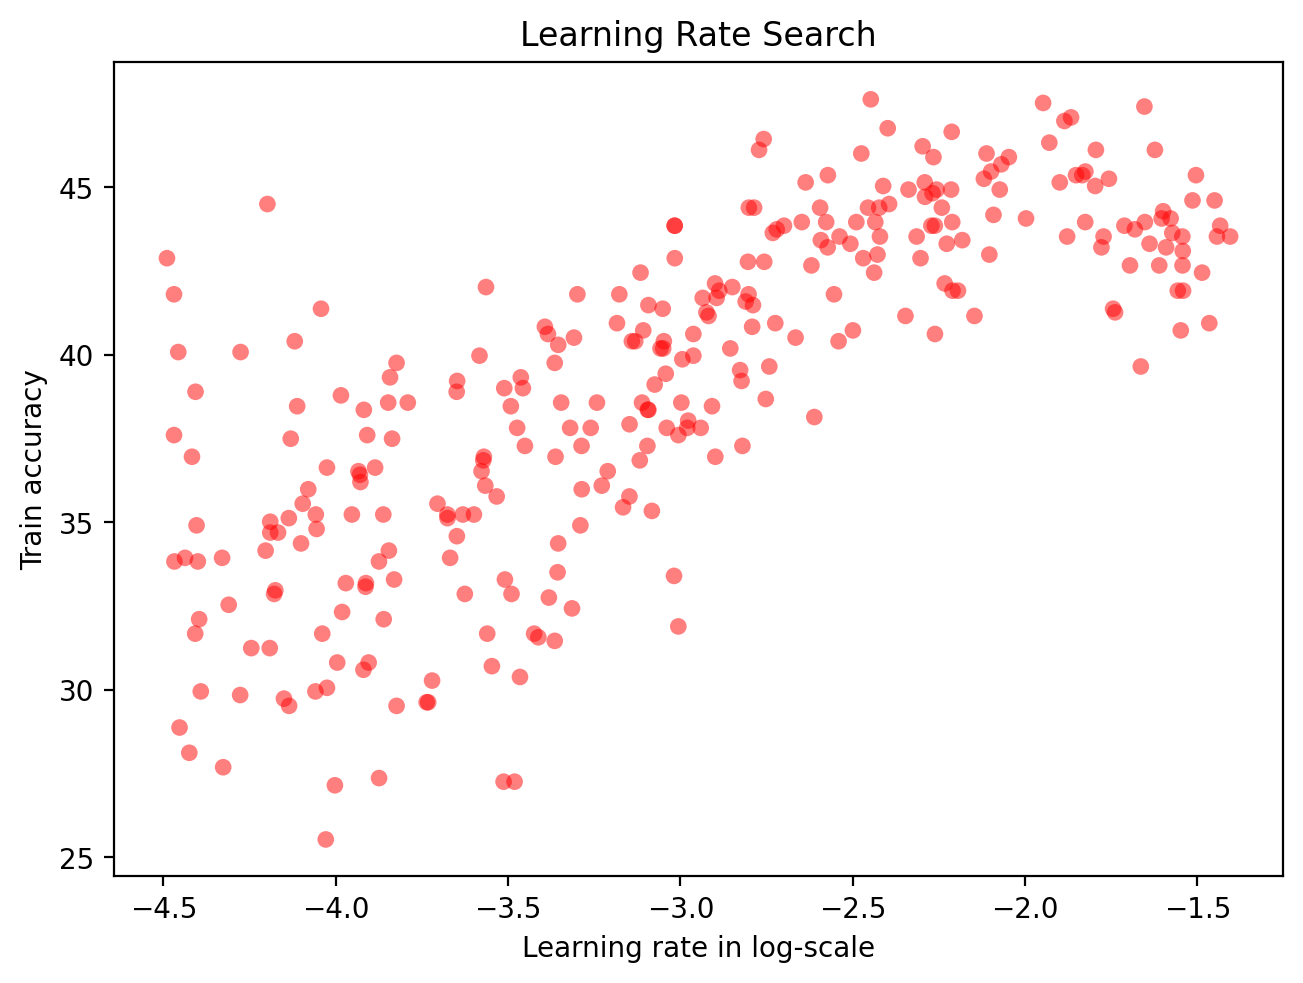

best lr 3.56922e-03 / log_lr -2.4474262972612677
----------------------------------------------------------------------------------------------------
M5 LR searching..


  0%|          | 0/300 [00:00<?, ?it/s]

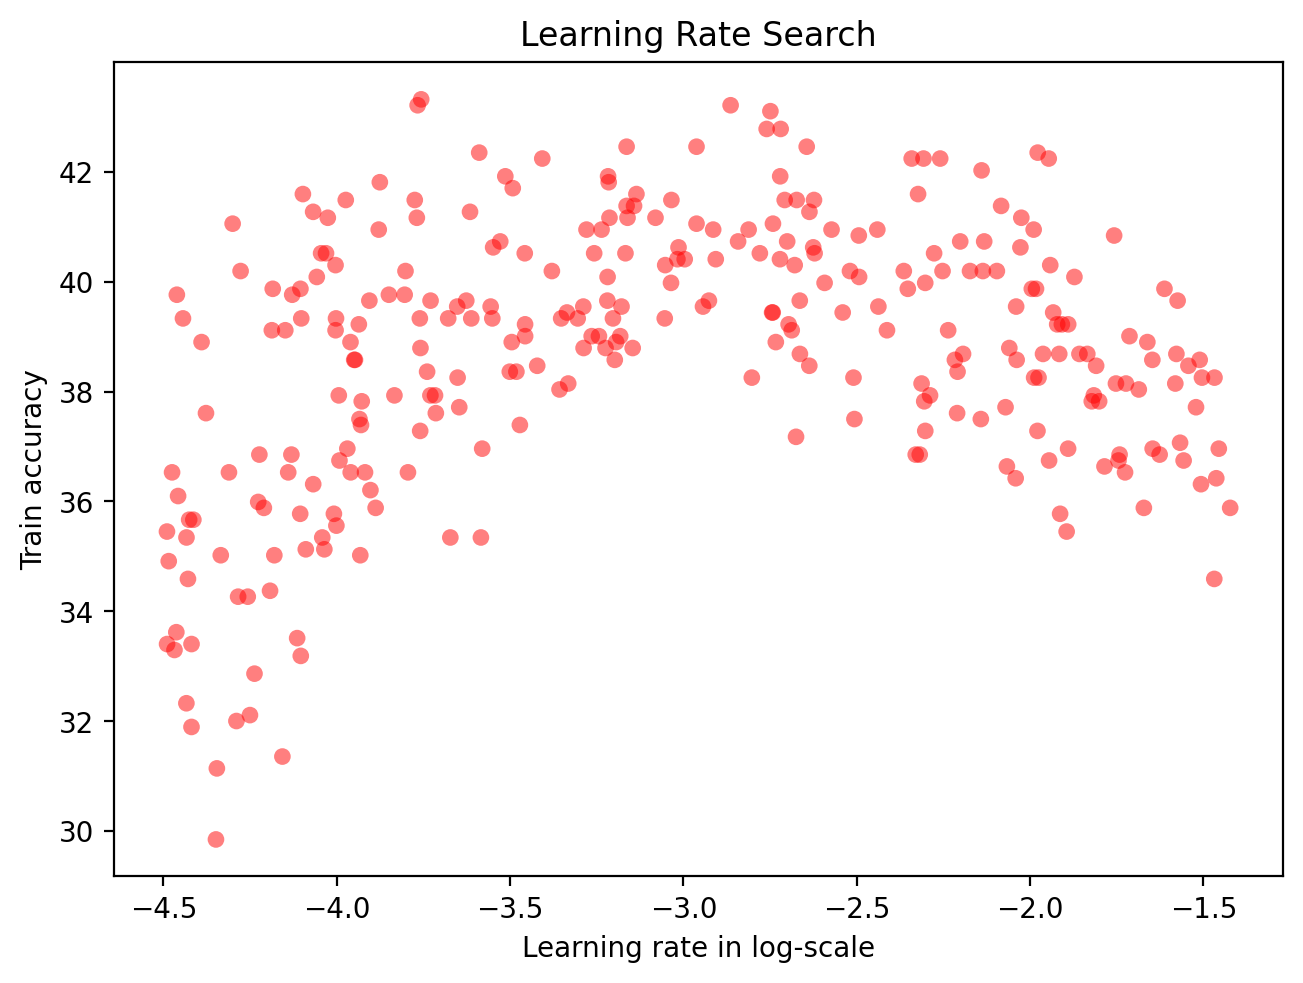

best lr 1.75222e-04 / log_lr -3.756411359876488
----------------------------------------------------------------------------------------------------
1D-ResNet LR searching..


  0%|          | 0/300 [00:00<?, ?it/s]

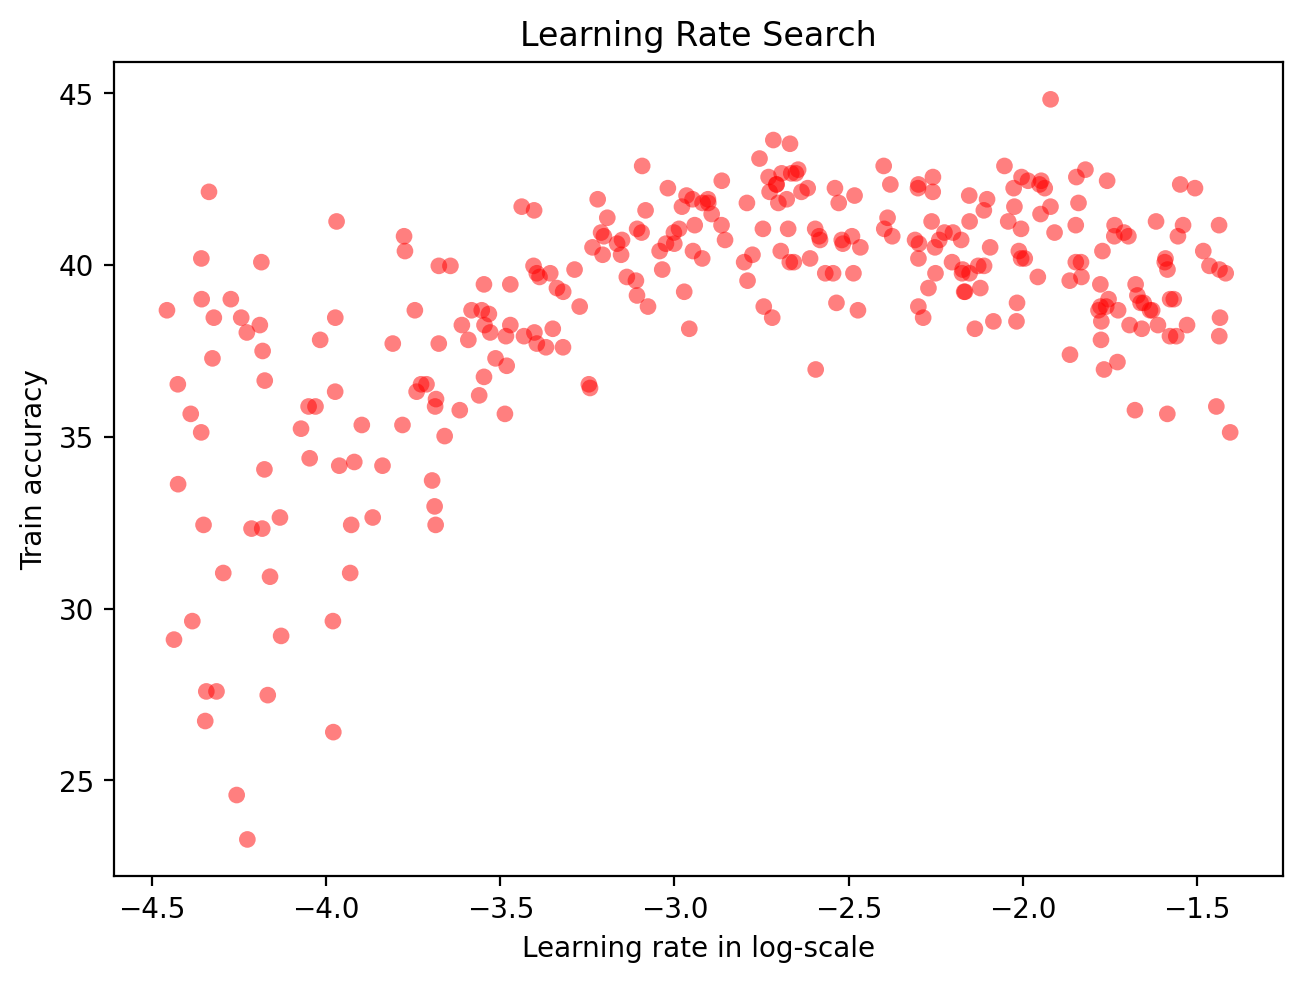

best lr 1.20272e-02 / log_lr -1.9198348031544756
----------------------------------------------------------------------------------------------------
1D-TinyResNet-no-age LR searching..


  0%|          | 0/300 [00:00<?, ?it/s]

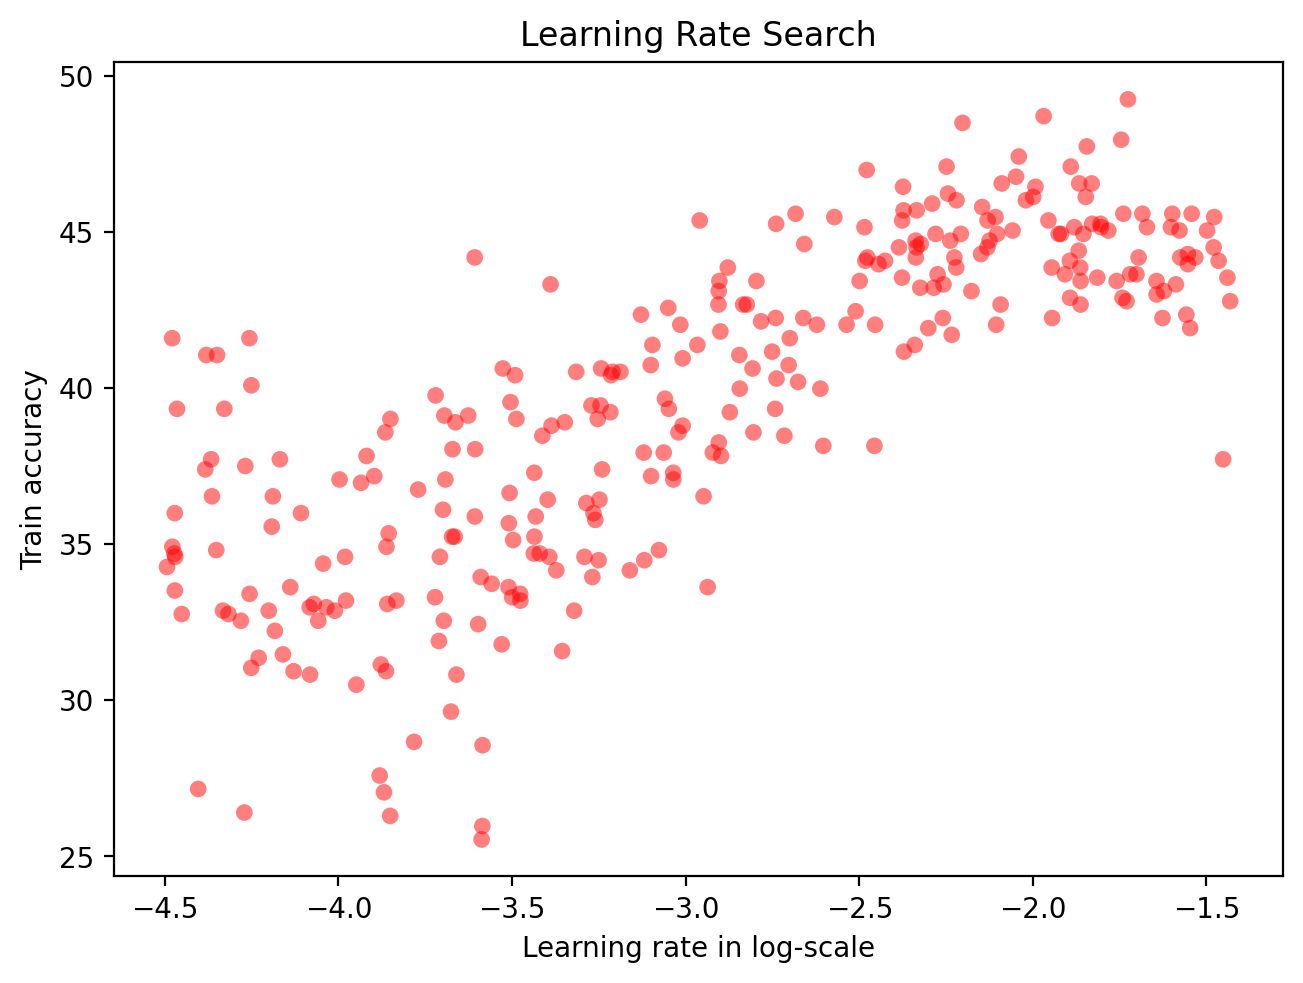

best lr 1.87853e-02 / log_lr -1.7261809278271913
----------------------------------------------------------------------------------------------------
[{'name': 'TinyCNN', 'generator': <function generate_TinyCNN at 0x7f52263195e0>, 'lr_start': 0.003569223162979871},
 {'name': 'M5', 'generator': <function generate_M5 at 0x7f5220246af0>, 'lr_start': 0.00017522200283228567},
 {'name': '1D-ResNet', 'generator': <function generate_ResNet at 0x7f5220246160>, 'lr_start': 0.012027218387034038},
 {'name': '1D-TinyResNet-no-age', 'generator': <function generate_TinyCNN at 0x7f52263195e0>, 'lr_start': 0.018785340532507418}]


In [37]:
for model_dict in model_pool:
    if model_dict['lr_start'] is None:
        print(f'{model_dict["name"]} LR searching..')
        model = model_dict['generator']().to(device)
        model.train()
        
        record = learning_rate_search(model, min_log_lr=-4.5, max_log_lr=-1.4, 
                                      trials=300, iters=30)
        
        draw_learning_rate_record(record)
        best_log_lr = record[np.argmax(np.array([v for lr, v in record]))][0]
        model_dict['lr_start'] = 10 ** best_log_lr
        
        print(f'best lr {model_dict["lr_start"]:.5e} / log_lr {best_log_lr}')
    else:
        print(f'{model_dict["name"]}: {model_dict["lr_start"]:.5e}')
        
    print('-' * 100)
        
pprint.pp(model_pool, width=150)

-- The number of iterations for each model: 375000--


  0%|          | 0/1500000 [00:00<?, ?it/s]

**************************************** TinyCNN train starts ****************************************


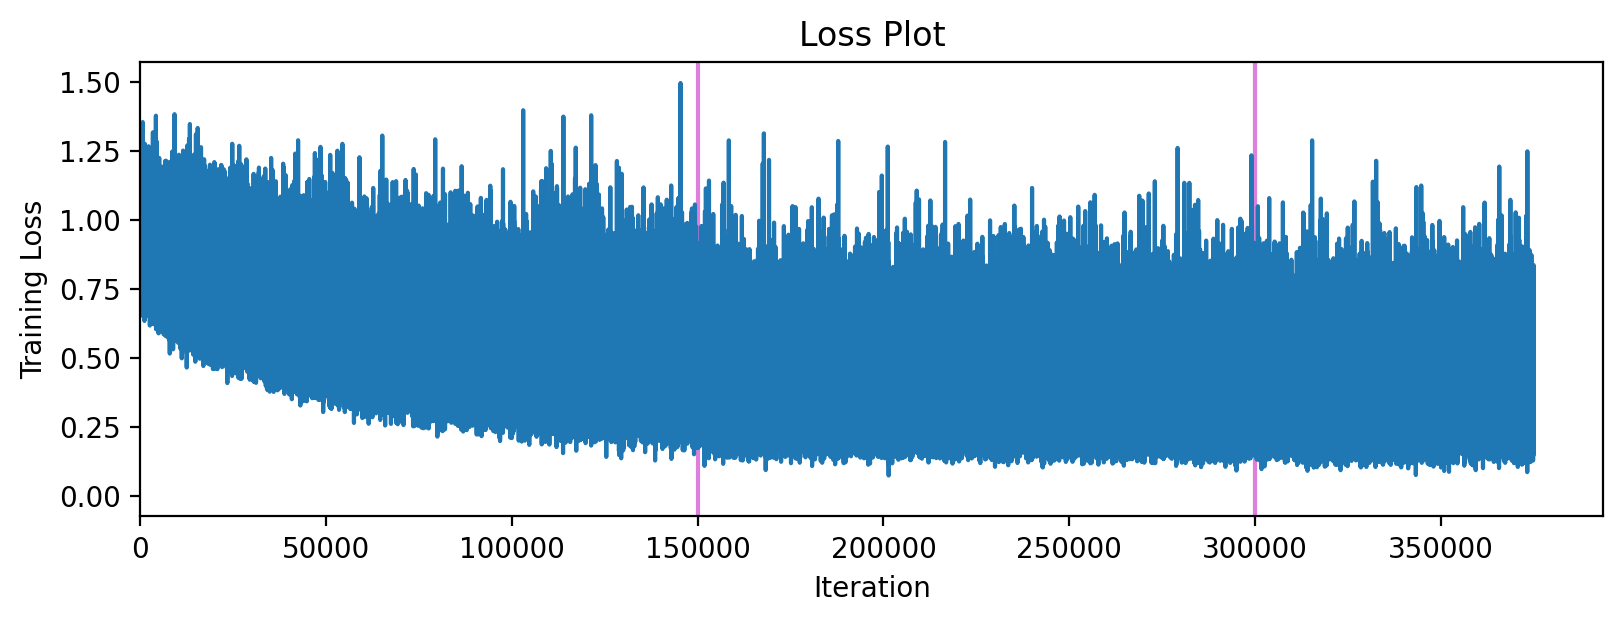

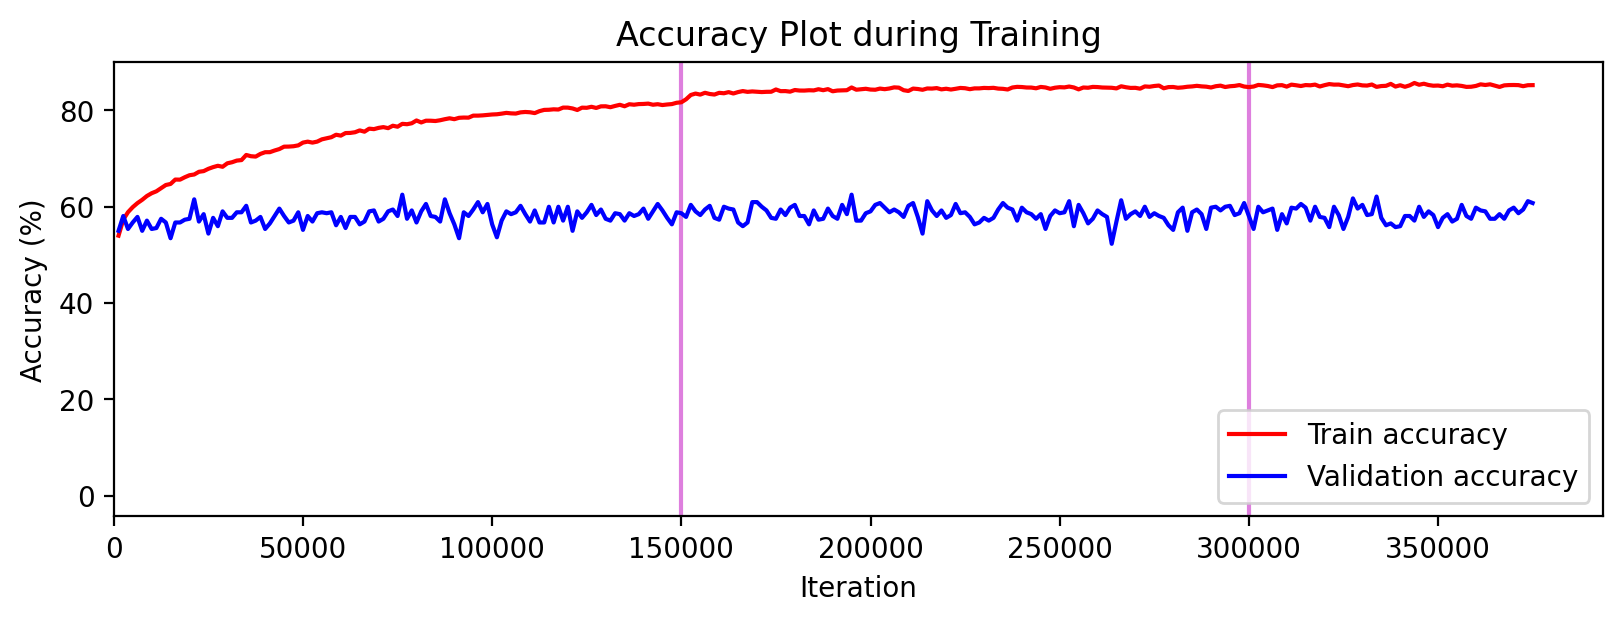


- 00 train accuracy 85.24%, best / last test accuracies 61.35% / 62.21% - file exists



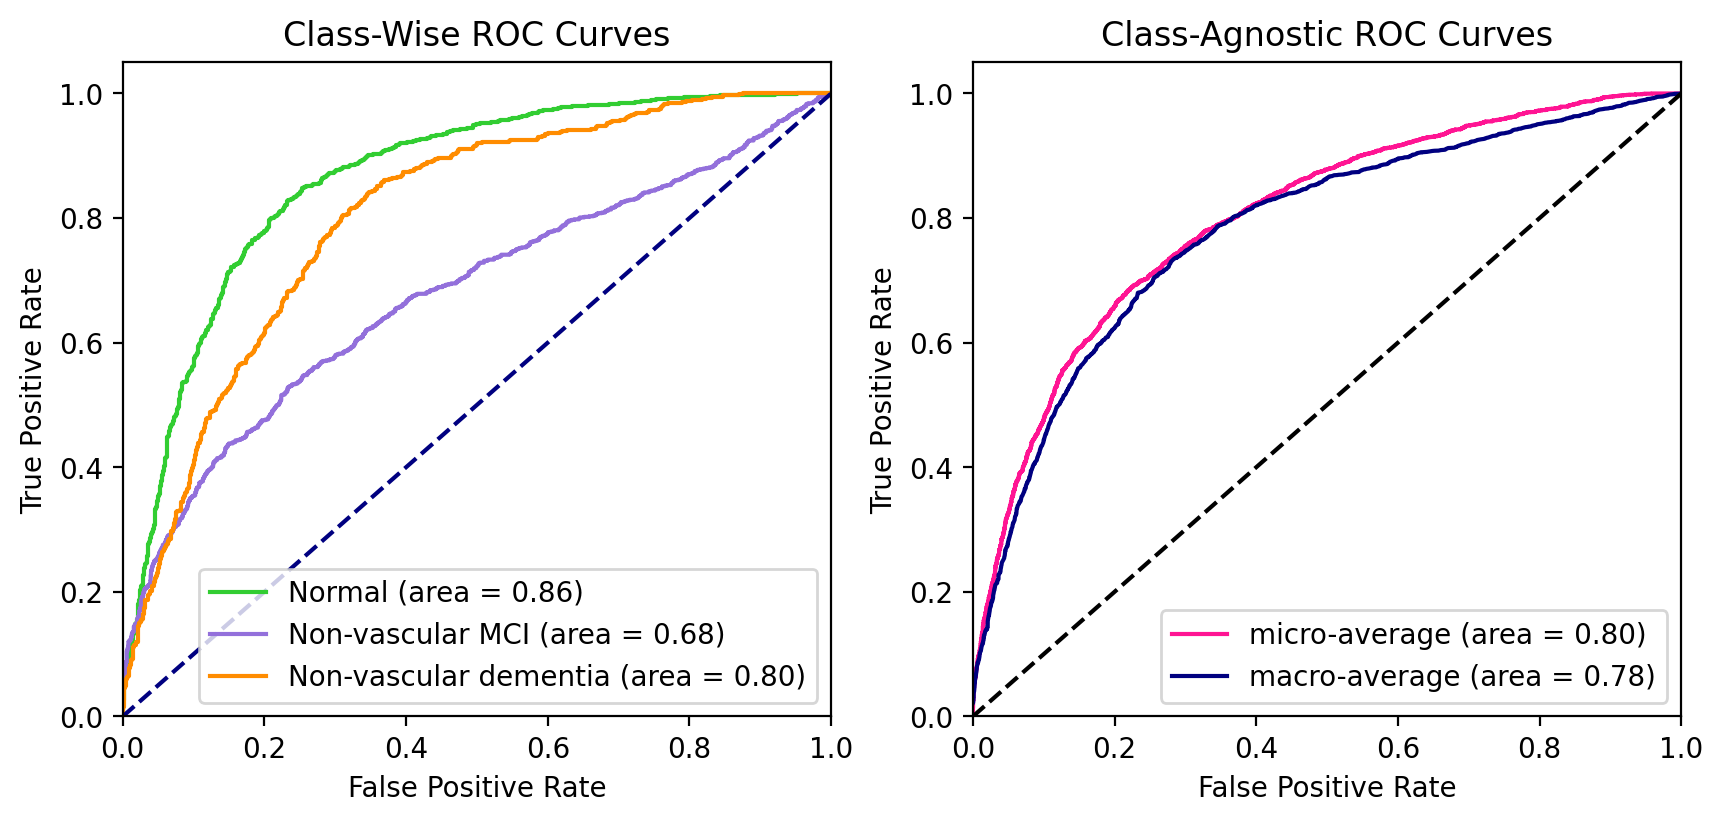

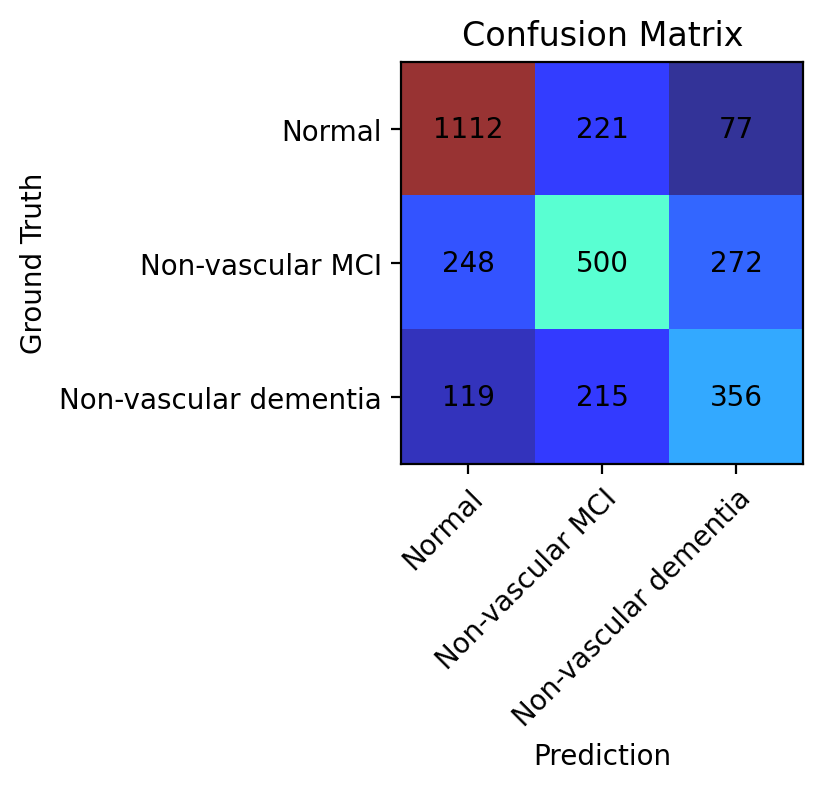





**************************************** M5 train starts ****************************************


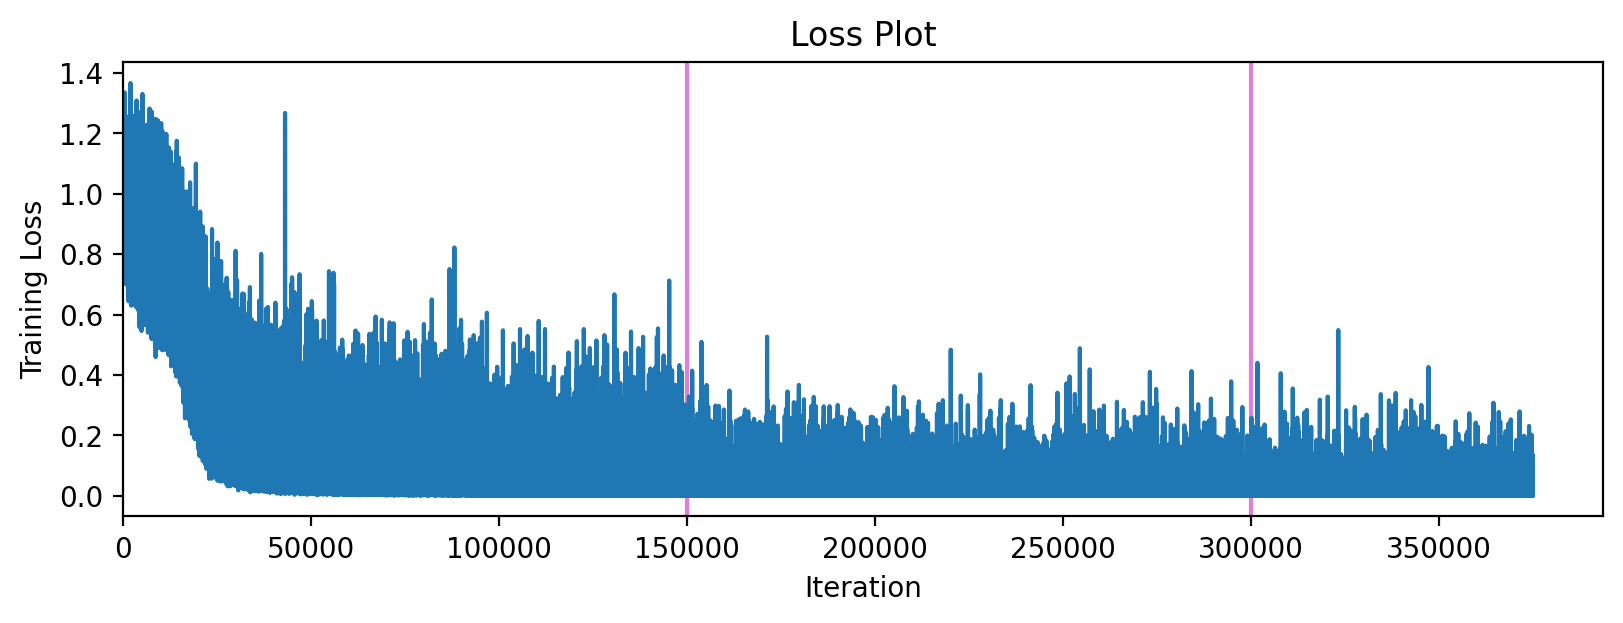

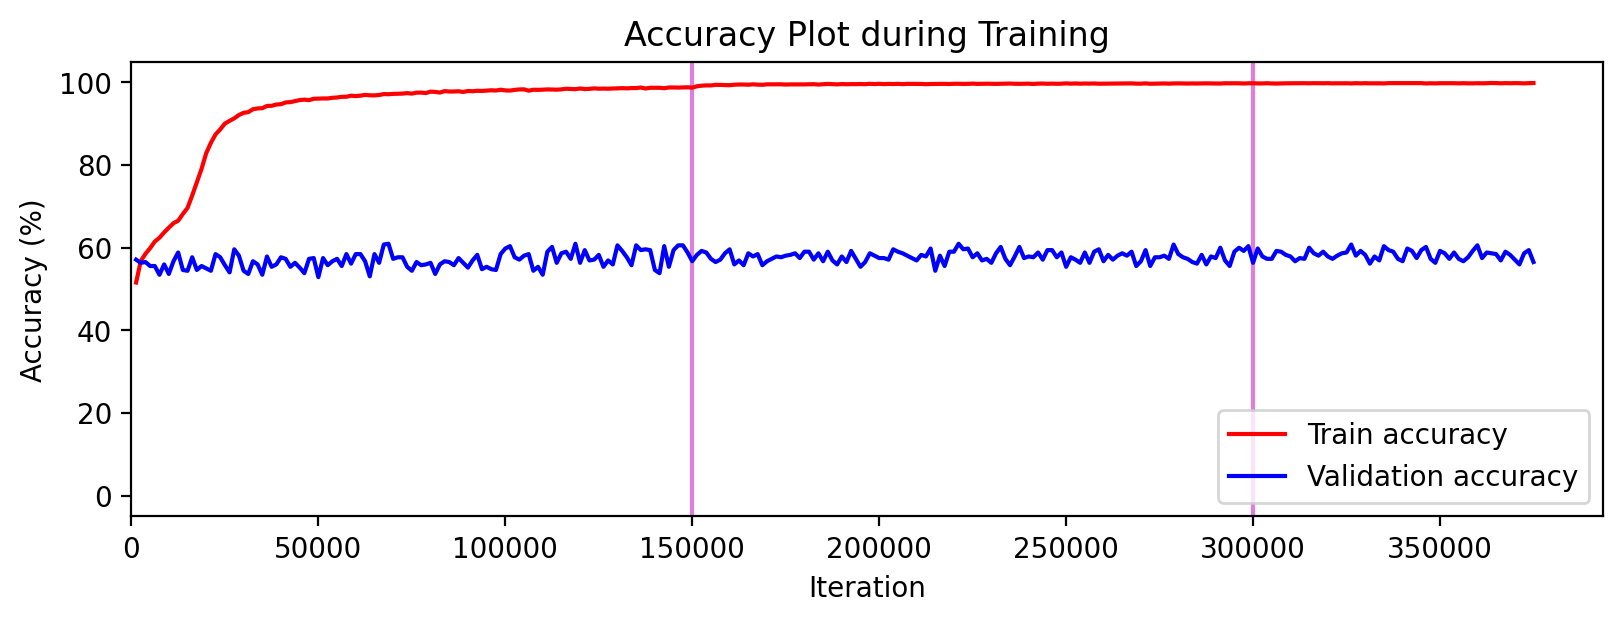


- 00 train accuracy 99.83%, best / last test accuracies 62.21% / 63.30% - file exists



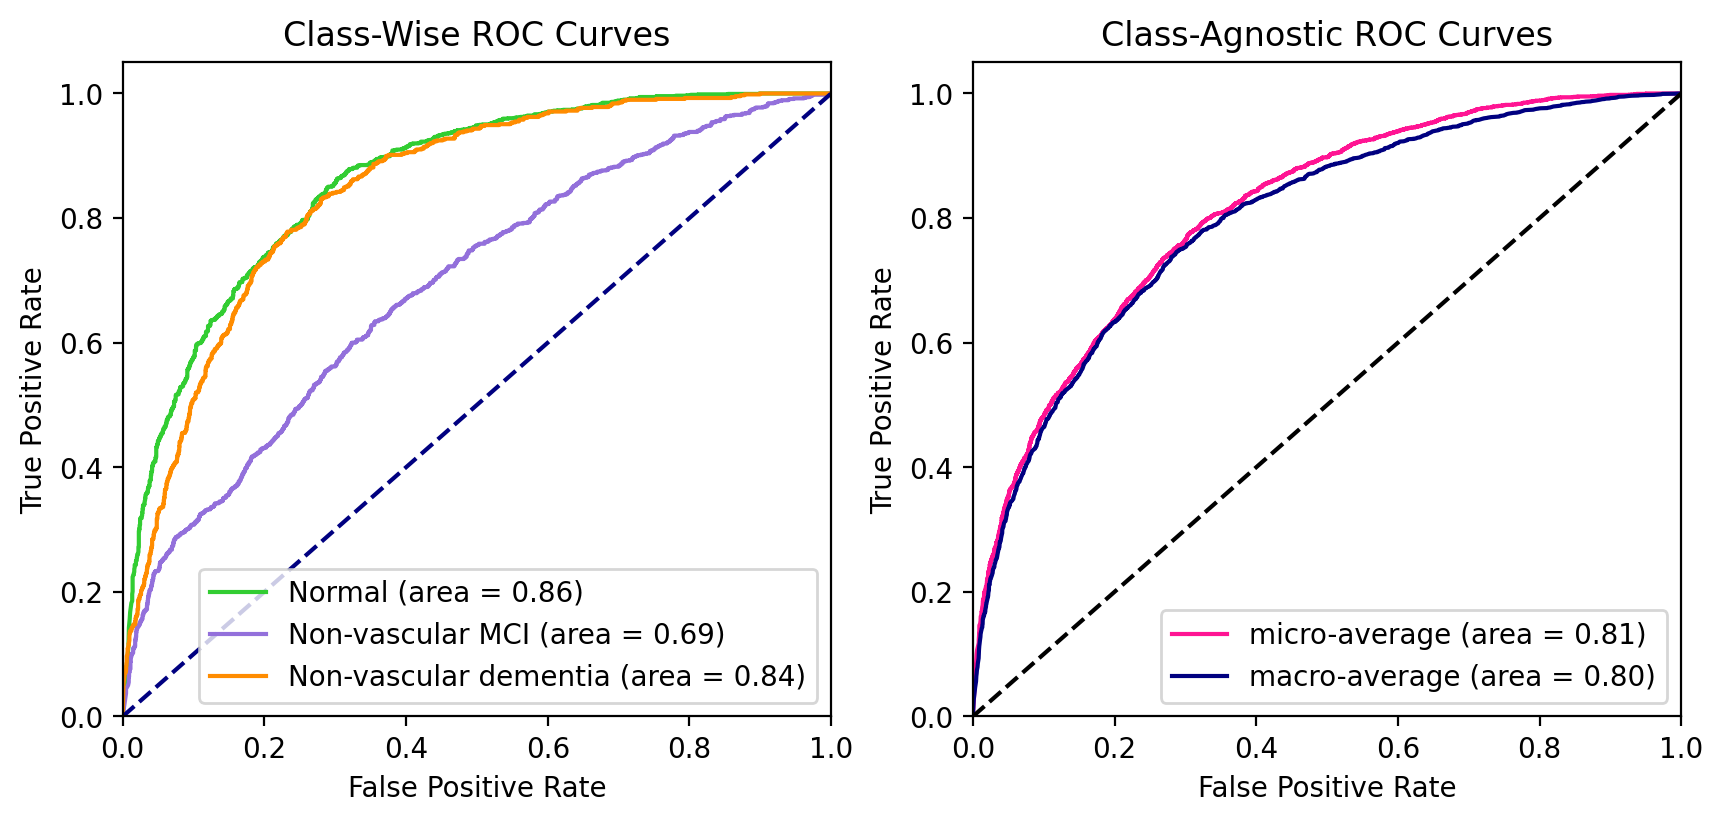

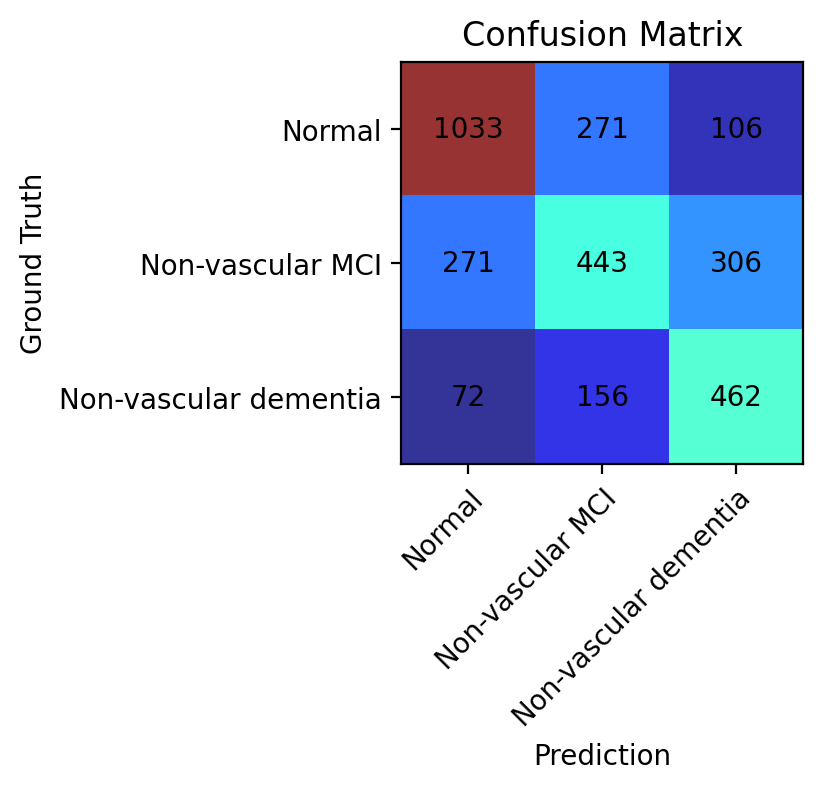





**************************************** 1D-ResNet train starts ****************************************


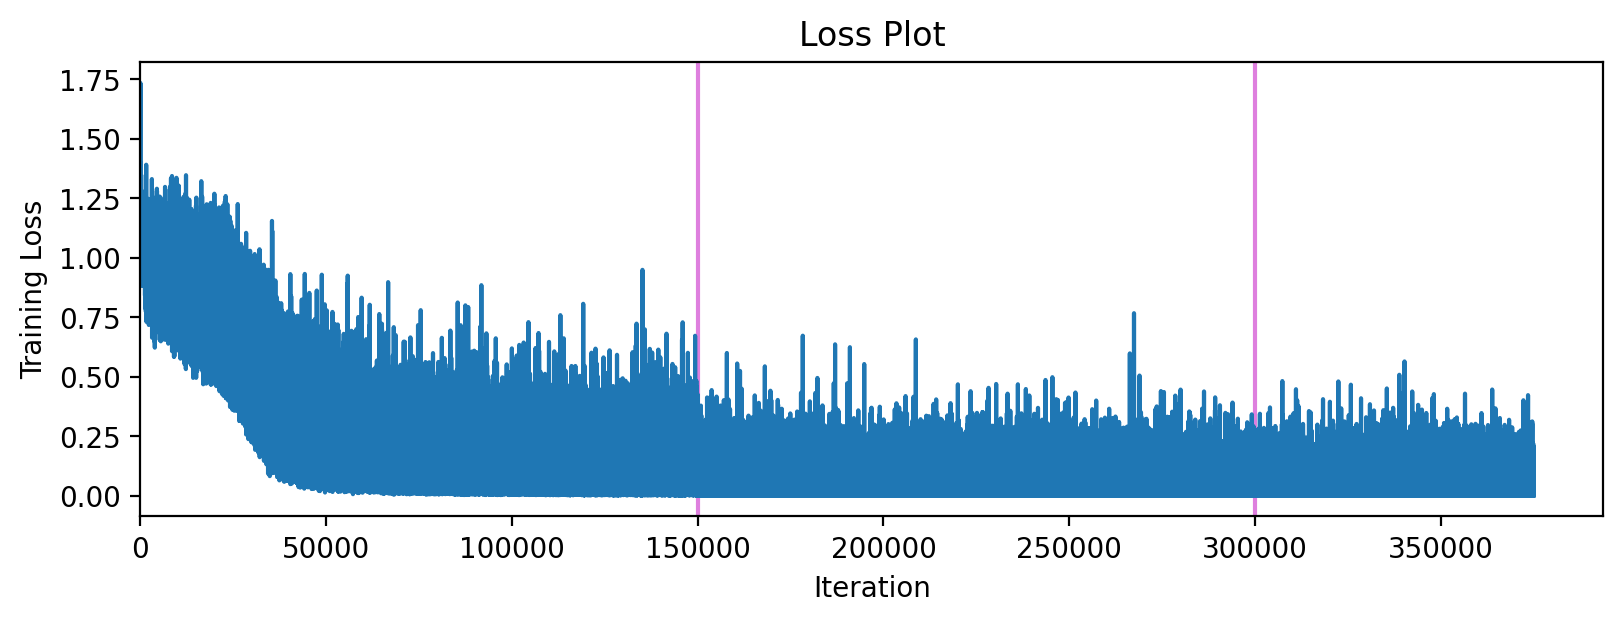

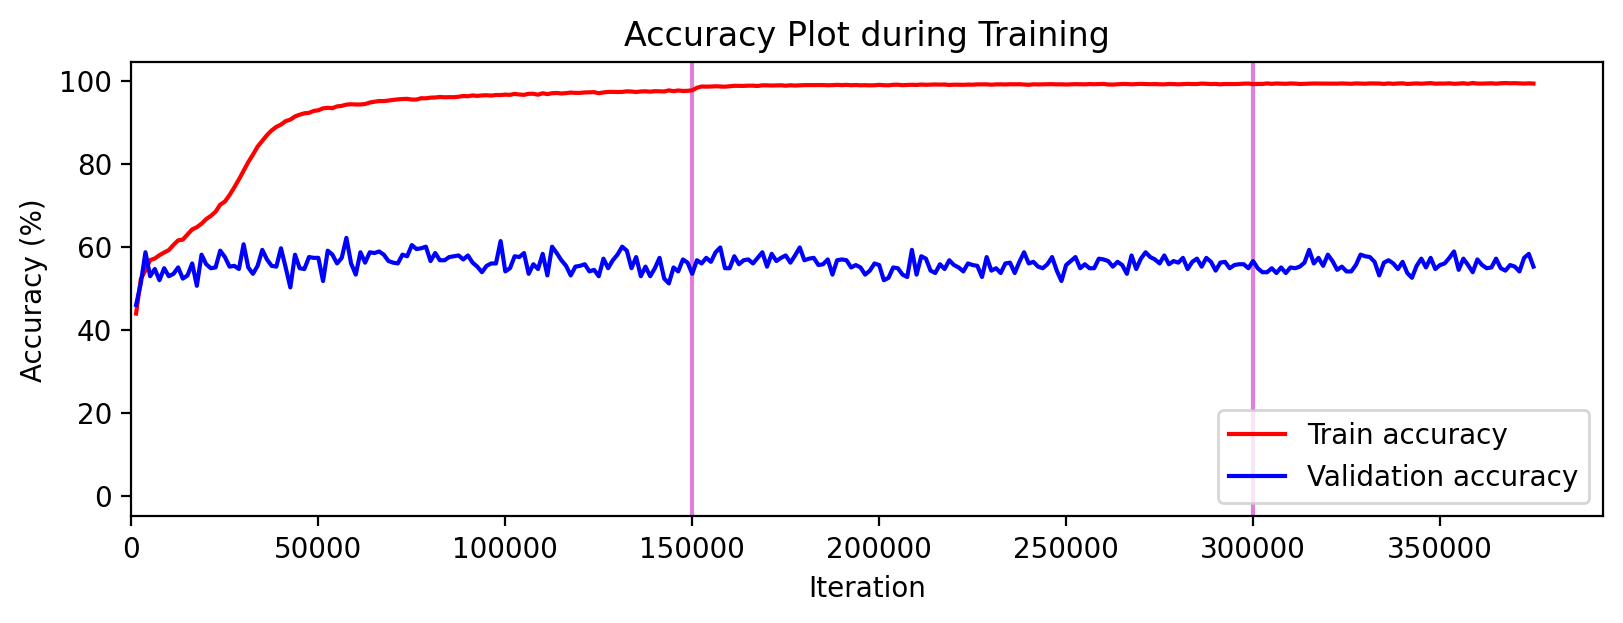


- 00 train accuracy 99.28%, best / last test accuracies 59.87% / 61.99% - file exists



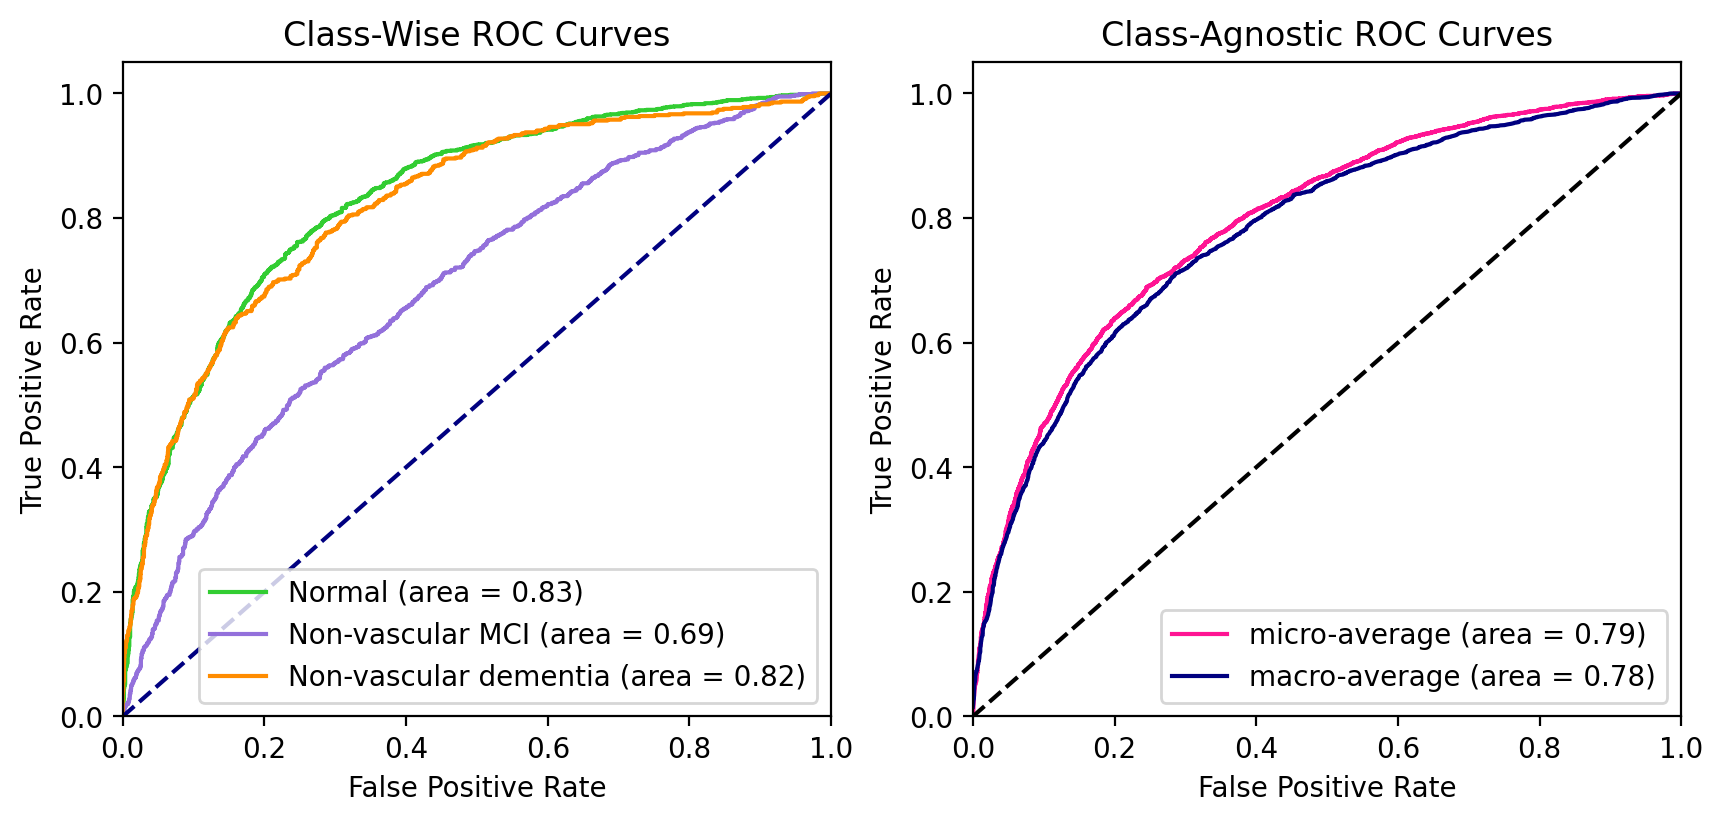

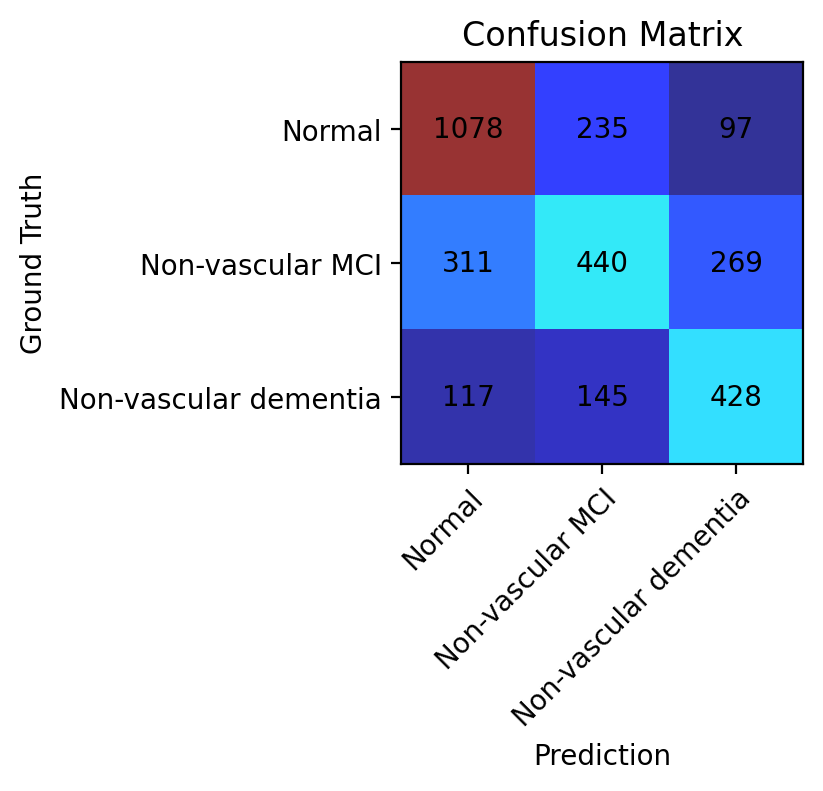





**************************************** 1D-TinyResNet-no-age train starts ****************************************


KeyboardInterrupt: 

In [47]:
file_check = True
save_model = True
draw_result = True

# log path
log_path = f'history_temp/{nb_fname}/'
os.makedirs(log_path, exist_ok=True)

# train iterations
n_repeats = 1
n_iters = 12500 * ((200 * 60) // crop_length)
history_interval = n_iters // 300
lr_decay_step = round(n_iters / 2.5)

print(f'-- The number of iterations for each model: {n_iters}--')

# progress bar
pbar = tqdm(total=len(model_pool) * n_iters * n_repeats)

# train process on model_pool
for model_dict in model_pool:
    print(f'{"*"*40} {model_dict["name"]} train starts {"*"*40}')
    best_r_test_acc = 0
    
    for r in range(n_repeats):
        if file_check:
            endwith = '' if n_repeats == 1 else f'_r{r:02d}'
            path = os.path.join(log_path, f'{model_dict["name"]}_log{endwith}')
            if os.path.isfile(path):
                log_dict = torch.load(path)
                # loss and accuracy plots
                if draw_result:
                    draw_loss_plot(log_dict["losses"], log_dict["lr_decay_step"])
                    draw_accuracy_history(log_dict["train_acc_history"], log_dict["val_acc_history"], 
                                          log_dict["history_interval"], log_dict["lr_decay_step"])
                script = f'- {r:02d} train accuracy {log_dict["train_acc_history"][-1]:.2f}%, '\
                f'best / last test accuracies {log_dict["best_test_accuracy"]:.2f}% / {log_dict["last_test_accuracy"]:.2f}% - file exists'
                print()
                print(script)
                print()
                pbar.update(n_iters)
                continue

        # load the model dict
        model = model_dict['generator']().to(device)
        model.train()
        lr_start = model_dict['lr_start']

        # configure for training
        optimizer = optim.AdamW(model.parameters(), lr=lr_start, weight_decay=0.0001)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_step, gamma=0.1)

        # log during training
        losses = []
        train_acc_history = []
        val_acc_history = []
        best_val_acc = 0
        correct, total = (0, 0)

        i = 1    
        while True:
            for sample_batched in train_loader:
                model.train()

                # load the data
                x = sample_batched['signal'].to(device)
                age = sample_batched['age'].to(device)
                target = sample_batched['class_label'].to(device)

                # forward pass
                output = model(x, age)
                pred = F.log_softmax(output, dim=1)
                loss = F.nll_loss(pred, target)

                # backward and update
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                scheduler.step()

                # train accuracy
                pred = pred.argmax(dim=-1)
                correct += pred.squeeze().eq(target).sum().item()
                total += pred.shape[0]

                # log
                losses.append(loss.item())
                pbar.update(1)
                i += 1

                # history
                if i % history_interval == 0:
                    train_acc = 100.0 * correct / total
                    train_acc_history.append(train_acc)
                    correct, total = (0, 0)

                    val_acc, _ = check_val_accuracy(model, repeat=5)
                    val_acc_history.append(val_acc)

                    if best_val_acc < val_acc:
                        best_val_acc = val_acc
                        best_model_state = deepcopy(model.state_dict())

                if i >= n_iters:
                    break
            if i >= n_iters:
                break
        
        # loss and accuracy plots
        if draw_result:
            draw_loss_plot(losses, lr_decay_step)
            draw_accuracy_history(train_acc_history, val_acc_history, history_interval, lr_decay_step)
            
        # calculate the test accuracies for best and last models
        last_model_state = deepcopy(model.state_dict())
        last_test_acc, last_test_confusion, last_test_debug, _, _ = check_test_accuracy(model, repeat=30)
        
        model.load_state_dict(best_model_state)
        best_test_acc, best_test_confusion, best_test_debug, _, _ = check_test_accuracy(model, repeat=30)

        # save the model if it is best among repeatedly trained models
        if save_model and best_r_test_acc < max(last_test_acc, best_test_acc):
            best_r_test_acc = max(last_test_acc, best_test_acc)
            model_state = last_model_state if best_test_acc < last_test_acc else best_model_state
            path = os.path.join(log_path, f'{model_dict["name"]}')
            torch.save(model_state, path)

        # leave the log
        endwith = '' if n_repeats == 1 else f'_r{r:02d}'
        path = os.path.join(log_path, f'{model_dict["name"]}_log{endwith}')
        log_dict = {}
        log_dict['model'] = model_dict['name']
        log_dict['starting_lr'] = lr_start
        log_dict['final_lr'] = optimizer.param_groups[-1]["lr"]
        log_dict['history_interval'] = history_interval
        log_dict['lr_decay_step'] = lr_decay_step
        log_dict['losses'] = losses
        log_dict['train_acc_history'] = train_acc_history
        log_dict['val_acc_history'] = val_acc_history
        log_dict['best_test_accuracy'] = best_test_acc
        log_dict['best_test_confusion'] = best_test_confusion
        log_dict['best_test_debug'] = best_test_debug
        log_dict['last_test_accuracy'] = last_test_acc
        log_dict['last_test_confusion'] = last_test_confusion
        log_dict['last_test_debug'] = last_test_debug
        torch.save(log_dict, path)

        script = f'- {r:02d} train accuracy {train_acc:.2f}%, '\
        f'best / last test accuracies {best_test_acc:.2f}% / {last_test_acc:.2f}%'
        print()
        print(script)
        print()
    
    if draw_result and save_model:
        model = model_dict['generator']().to(device)
        path = os.path.join(log_path, f'{model_dict["name"]}')
        model.load_state_dict(torch.load(path))
        temp_result = check_test_accuracy(model, repeat=30)
        test_acc, test_confusion, test_debug, score, target = temp_result
        draw_roc_curve(score, target)
        draw_confusion(test_confusion)
        print('\n' * 2)
    print()